## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 10 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 512 

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.1, 0.5]
redice_lr_patient = [5, 10]

In [8]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    # Callbacks, reduce learning rate
    reduce_lr = keras.callbacks.ReduceLROnPlateau(factor=reduce_factor, min_lr=1e-12, monitor='val_loss', patience=reduce_patient, verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

W0728 01:15:05.725587  2284 deprecation_wrapper.py:119] From C:\Users\Ychu\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0728 01:15:05.726586  2284 deprecation_wrapper.py:119] From C:\Users\Ychu\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0728 01:15:05.734588  2284 deprecation_wrapper.py:119] From C:\Users\Ychu\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0728 01:15:05.856598  2284 deprecation_wrapper.py:119] From C:\Users\Ychu\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.



Numbers of exp: 0, reduce_factor: 0.10, reduce_patient: 5


W0728 01:15:06.293632  2284 deprecation_wrapper.py:119] From C:\Users\Ychu\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0728 01:15:06.302633  2284 deprecation_wrapper.py:119] From C:\Users\Ychu\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.

W0728 01:15:06.400642  2284 deprecation.py:323] From C:\Users\Ychu\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
__________

50000/50000 [==============================] - 7s 132us/step - loss: 1.2884 - acc: 0.5511 - val_loss: 1.4901 - val_acc: 0.4717
Epoch 8/10
50000/50000 [==============================] - 7s 132us/step - loss: 1.2484 - acc: 0.5671 - val_loss: 1.4695 - val_acc: 0.4792
Epoch 9/10
50000/50000 [==============================] - 7s 131us/step - loss: 1.2147 - acc: 0.5774 - val_loss: 1.4614 - val_acc: 0.4799
Epoch 10/10
50000/50000 [==============================] - 7s 132us/step - loss: 1.1790 - acc: 0.5895 - val_loss: 1.4551 - val_acc: 0.4932
Numbers of exp: 3, reduce_factor: 0.50, reduce_patient: 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
bat

50000/50000 [==============================] - 8s 156us/step - loss: 1.4404 - acc: 0.4878 - val_loss: 1.5862 - val_acc: 0.4297
Epoch 4/10
50000/50000 [==============================] - 8s 154us/step - loss: 1.3731 - acc: 0.5116 - val_loss: 1.6260 - val_acc: 0.4155
Epoch 5/10
50000/50000 [==============================] - 8s 167us/step - loss: 1.3245 - acc: 0.5256 - val_loss: 1.8227 - val_acc: 0.3783
Epoch 6/10
50000/50000 [==============================] - 8s 164us/step - loss: 1.2701 - acc: 0.5469 - val_loss: 1.7210 - val_acc: 0.4132
Epoch 7/10
50000/50000 [==============================] - 8s 162us/step - loss: 1.2302 - acc: 0.5628 - val_loss: 1.5650 - val_acc: 0.4452
Epoch 8/10
50000/50000 [==============================] - 8s 157us/step - loss: 1.1834 - acc: 0.5799 - val_loss: 1.7653 - val_acc: 0.4240
Epoch 9/10
50000/50000 [==============================] - 8s 160us/step - loss: 1.1466 - acc: 0.5925 - val_loss: 1.5258 - val_acc: 0.4717
Epoch 10/10
50000/50000 [====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 11s 228us/step - loss: 1.7430 - acc: 0.3900 - val_loss: 2.0960 - val_acc: 0.3057
Epoch 2/10
50000/50000 [==============================] - 8s 166us/step - loss: 1.4854 - acc: 0.4736 - val_loss: 2.2653 - val_acc: 0.2864
Epoch 3/10
50000/50000 [==============================] - 8s 166us/step - loss: 1.3876 - acc: 0.5086 - val_loss: 2.4320 - val_acc: 0.2888
Epoch 4/10
50000/50000 [==============================] - 8s 167us/step - loss: 1.3098 - acc: 0.5326 - val_loss: 2.9323 - val_acc: 0.2009
Epoch 5/10
50000/50000 [==============================] - 8s 167us/step - loss: 1.2533 - acc: 0.5539 - val_loss: 1.7691 - val_acc: 0.3749
Epoch 6/10
50000/50000 [==============================] - 8s 167us/step - loss: 1.2023 - acc: 0.5717 - val_loss: 2.0885 - val_acc: 0.3400
Epoch 7/10
50000/50000 [==============================] - 8s 160us/step - loss: 1.1625 - acc: 0.5880 - val_loss: 2.2684 -

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 10s 200us/step - loss: 1.7450 - acc: 0.3889 - val_loss: 4.4308 - val_acc: 0.1781
Epoch 2/10
50000/50000 [==============================] - 7s 144us/step - loss: 1.4979 - acc: 0.4718 - val_loss: 2.5761 - val_acc: 0.2344
Epoch 3/10
50000/50000 [==============================] - 7s 143us/step - loss: 1.3919 - acc: 0.5073 - val_loss: 1.9418 - val_acc: 0.3529
Epoch 4/10
50000/50000 [==============================] - 7s 145us/step - loss: 1.3205 - acc: 0.5340 - val_loss: 2.0056 - val_acc: 0.3319
Epoch 5/10
50000/50000 [==============================] - 7s 146us/step - loss: 1.2648 - acc: 0.5512 - val_loss: 1.8846 - val_acc: 0.3491
Epoch 6/10
50000/50000 [==============================] - 8s 159us/step - loss: 1.2191 - acc: 0.5682 - val_loss: 2.1117 - val_acc: 0.3192
Epoch 7/10
50000/50000 [==============================] - 8s 152us/step - loss: 1.1707 - acc: 0.5842 - val_loss: 1.8494 -

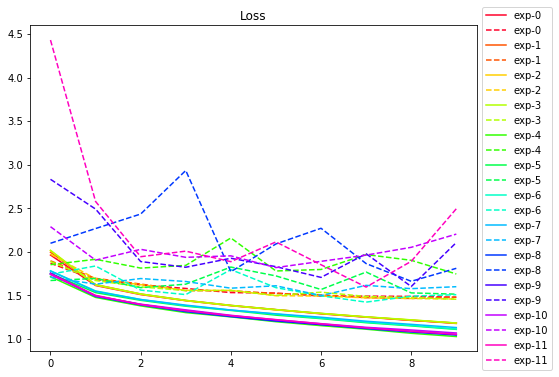

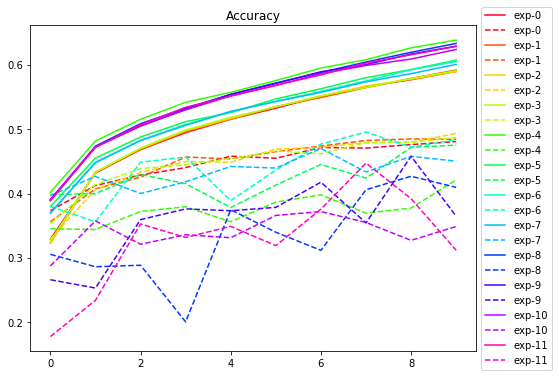

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [10]:
model.save("My_model.h5")

In [15]:
model_new = keras.models.load_model("My_model.h5")
loss, acc = model_new.evaluate(x_test, y_test)
print(f'Accuracy :{acc}')
print(f'Loss: {loss}')

10000/10000 [==============================] - 2s 203us/step
Accuracy :0.312
Loss: 2.4925452308654785
